In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from transformers import TFViTModel
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

c:\Users\abini\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20

# Dataset Paths
base_dir = 'Dataset'  # Update with your dataset path
categories = ['CT_COVID', 'CT_NonCOVID', 'Tuberculosis', 'Non_Tuberculosis']


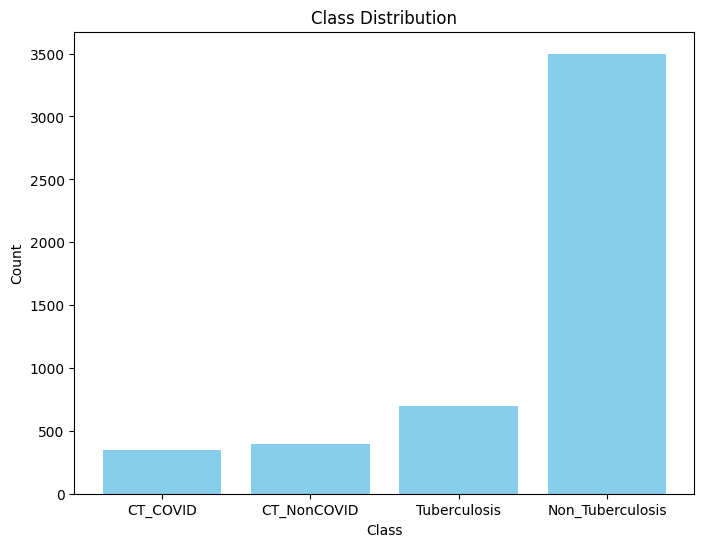

In [40]:
# Plot the distribution of classes
plt.figure(figsize=(8, 6))
unique, counts = np.unique(y, return_counts=True)
plt.bar(categories, counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


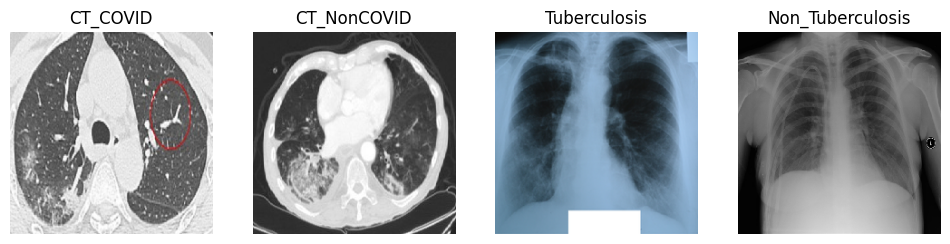

In [41]:
# Display sample images from each class
def plot_sample_images(base_dir, categories, image_size):
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        folder = os.path.join(base_dir, category)
        img_path = os.path.join(folder, os.listdir(folder)[0])  # First image in the folder
        img = load_img(img_path, target_size=image_size)
        plt.subplot(1, len(categories), i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

plot_sample_images(base_dir, categories, IMAGE_SIZE)


In [6]:
# Load and Preprocess Dataset
def load_data(base_dir, categories, img_size):
    images = []
    labels = []
    for idx, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0  # Normalize
                images.append(img_array)
                labels.append(idx)  # Use the index as the label
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)


In [7]:
# Load the dataset
X, y = load_data(base_dir, categories, IMAGE_SIZE)

# Split Data into Train, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# One-Hot Encode Labels
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (3462, 224, 224, 3), Validation: (742, 224, 224, 3), Test: (742, 224, 224, 3)


In [8]:
def build_hybrid_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Vision Transformer
    vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

    # Define a function for the Lambda layer with explicit output shape
    def get_vit_features(inputs):
        # Reshape the input tensor to have the channels dimension as the last dimension
        reshaped_inputs = tf.transpose(inputs, perm=[0, 3, 1, 2]) # Change order
        features = vit_model(reshaped_inputs).last_hidden_state
        # The output shape is (batch_size, sequence_length, hidden_size)
        # For ViT-Base, sequence_length is 197 and hidden_size is 768
        return tf.reshape(features, (-1, 197, 768))  # Reshape to the desired output shape

    # Specify the output_shape argument for the Lambda layer
    vit_features = tf.keras.layers.Lambda(get_vit_features, output_shape=(197, 768))(inputs)

    vit_features = GlobalAveragePooling1D()(vit_features)

    # DenseNet-201
    densenet_model = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
    densenet_model.trainable = False
    densenet_features = densenet_model(inputs)
    densenet_features = GlobalAveragePooling2D()(densenet_features)

    # Feature Fusion
    fused_features = Concatenate()([vit_features, densenet_features])

    # Classification Head
    x = Dense(256, activation="relu")(fused_features)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

In [9]:
# Build Model
model = build_hybrid_model((*IMAGE_SIZE, 3), NUM_CLASSES)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [10]:
# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1276s 11s/step - accuracy: 0.8464 - loss: 0.4511 - val_accuracy: 0.9515 - val_loss: 0.1017
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1181s 11s/step - accuracy: 0.9396 - loss: 0.1398 - val_accuracy: 0.9650 - val_loss: 0.0842
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1199s 11s/step - accuracy: 0.9556 - loss: 0.1115 - val_accuracy: 0.9555 - val_loss: 0.0901
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1452s 13s/step - accuracy: 0.9499 - loss: 0.0990 - val_accuracy: 0.9650 - val_loss: 0.0757
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1558s 14s/step - accuracy: 0.9619 - loss: 0.0886 - val_accuracy: 0.9528 - val_loss: 0.0986
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1358s 12s/step - accuracy: 0.9592 - loss: 0.0899 - val_accuracy: 0.9690 - val_loss: 0.0691
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1346s 12s/step - accuracy: 0.9713 - loss: 0.0725 - val_accuracy: 0.9663 - val_loss: 0.0721
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1100s 10s/step - accuracy: 0.9743 - loss: 0

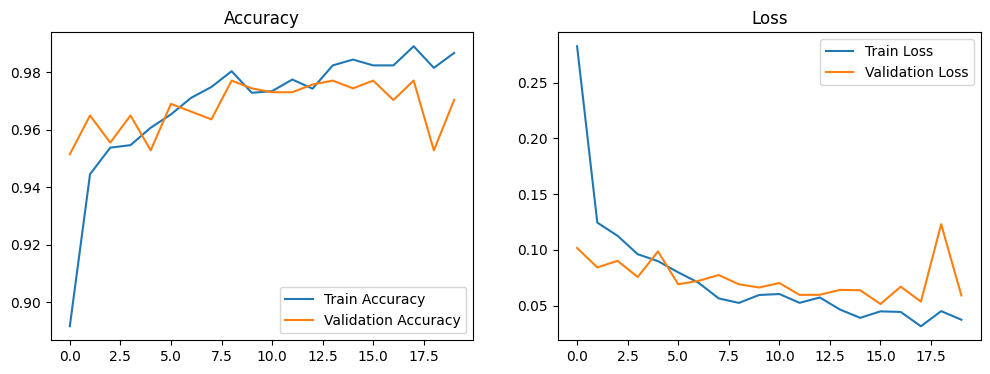

In [17]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [15]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 174s 7s/step - accuracy: 0.9617 - loss: 0.1014
Test Accuracy: 96.90%


In [20]:
# Prediction on User Input
def predict_image(model, img_path, img_size):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_names = ['Covid Affected', 'Non-Covid Affected', 'Tuberculosis Affected', 'Non-Tuberculosis Affected']
    return class_names[predicted_class], prediction


In [21]:
# Example Prediction 1
img_path = 'test_image_1(NormalPerson).png'  # Update with test image path
predicted_class, prediction = predict_image(model, img_path, IMAGE_SIZE)
print(f"Predicted Class: {predicted_class}, Confidence: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Class: Non-Tuberculosis Affected, Confidence: [[3.6403597e-10 5.2047320e-12 1.1028310e-09 1.0000000e+00]]


In [22]:
# Example Prediction 2
img_path = 'test_image_3(Tuberculosis_affected).png'  # Update with test image path
predicted_class, prediction = predict_image(model, img_path, IMAGE_SIZE)
print(f"Predicted Class: {predicted_class}, Confidence: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Predicted Class: Tuberculosis Affected, Confidence: [[3.6408681e-09 3.2078862e-09 9.9999988e-01 1.7321318e-07]]


In [23]:
# Example Prediction 3
img_path = 'test_image_4(Non_covid_affected).png'  # Update with test image path
predicted_class, prediction = predict_image(model, img_path, IMAGE_SIZE)
print(f"Predicted Class: {predicted_class}, Confidence: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Predicted Class: Non-Covid Affected, Confidence: [[1.4989220e-03 9.9849689e-01 2.6454677e-07 3.8875273e-06]]


In [24]:
# Example Prediction 4
img_path = 'test_image_2(Covid_Affected).png'  # Update with test image path
predicted_class, prediction = predict_image(model, img_path, IMAGE_SIZE)
print(f"Predicted Class: {predicted_class}, Confidence: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Predicted Class: Covid Affected, Confidence: [[9.9826139e-01 1.7348834e-03 1.7384682e-06 1.8954946e-06]]


In [25]:
# Generate Predictions on Test Data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step


In [26]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

Classification Report:
                  precision    recall  f1-score   support

        CT_COVID       0.78      0.92      0.84        53
     CT_NonCOVID       0.92      0.76      0.83        59
    Tuberculosis       0.99      0.96      0.98       105
Non_Tuberculosis       0.99      1.00      1.00       525

        accuracy                           0.97       742
       macro avg       0.92      0.91      0.91       742
    weighted avg       0.97      0.97      0.97       742



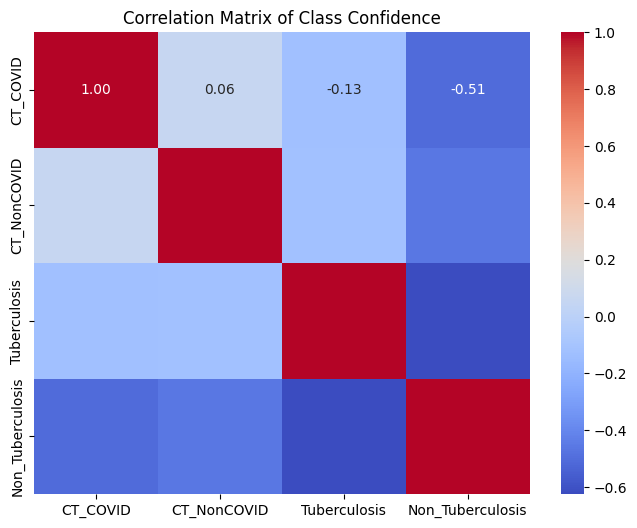

In [27]:
# Correlation Matrix for Confidence Values (Optional Insight)
correlation_matrix = np.corrcoef(y_pred.T)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=categories, yticklabels=categories)
plt.title("Correlation Matrix of Class Confidence")
plt.show()

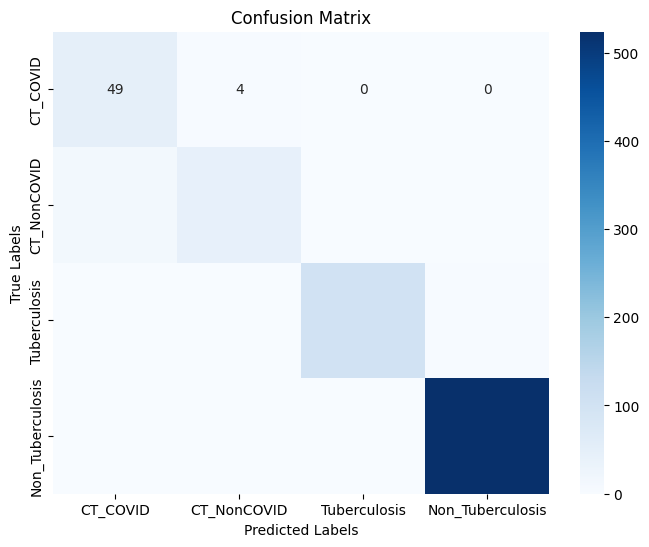

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

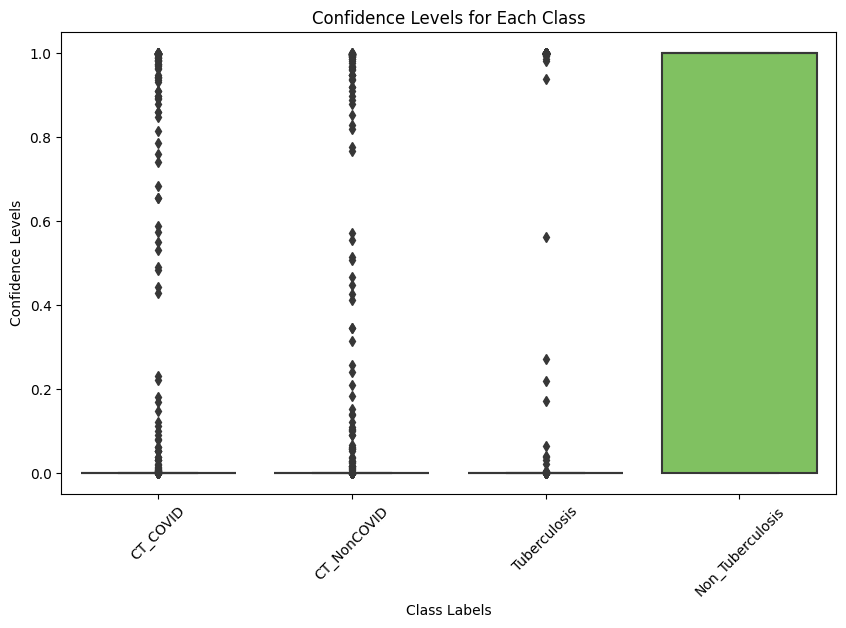

In [29]:
# Visualize confidence levels for each class
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(y_pred, columns=categories), palette="viridis")
plt.title("Confidence Levels for Each Class")
plt.xlabel("Class Labels")
plt.ylabel("Confidence Levels")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()


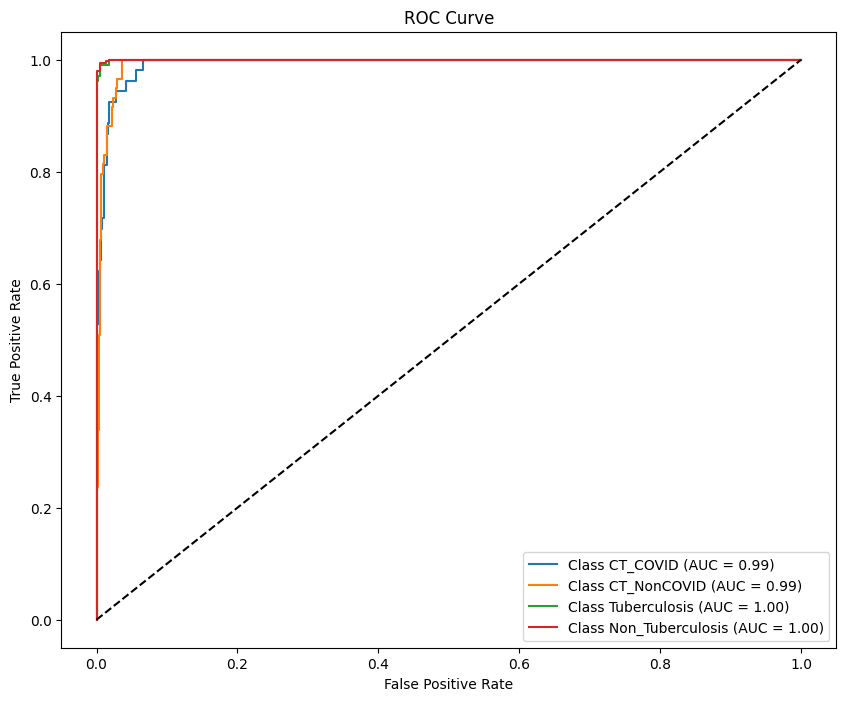

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve
y_test_binarized = label_binarize(y_true_classes, classes=range(NUM_CLASSES))
y_pred_binarized = label_binarize(y_pred_classes, classes=range(NUM_CLASSES))

# Compute ROC Curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {categories[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


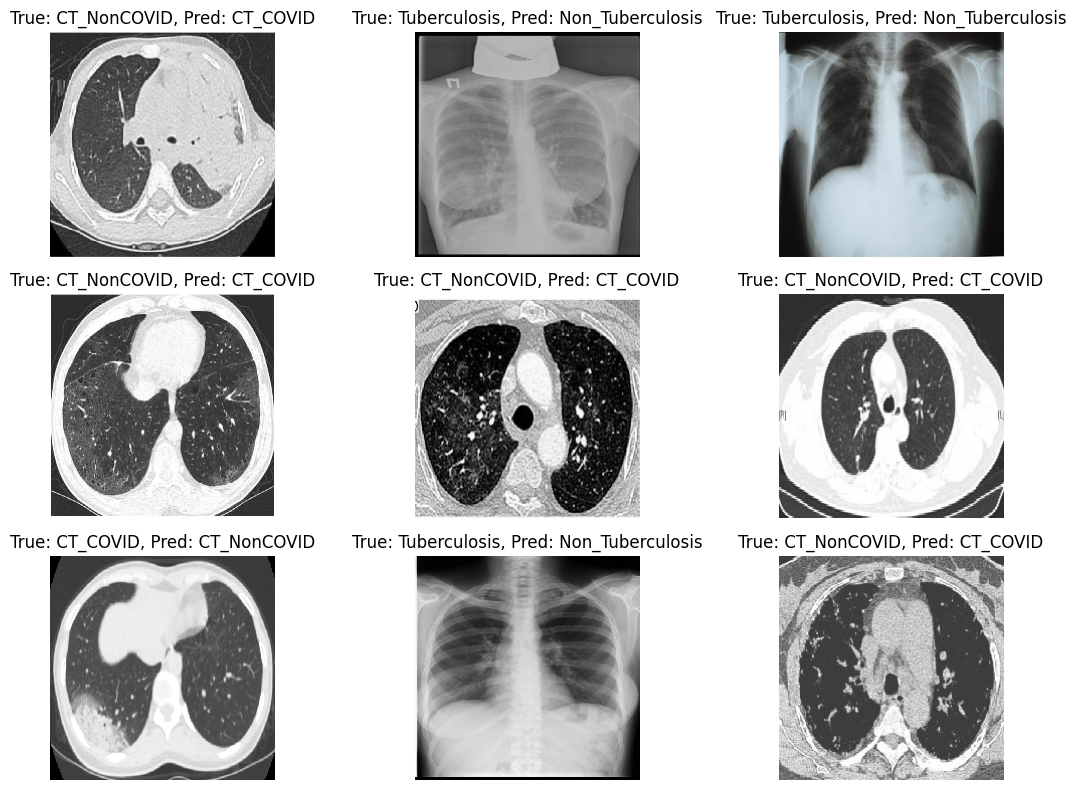

In [38]:
# Identify misclassified samples
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

def plot_misclassified_images(X_test, y_true, y_pred, misclassified_indices, categories):
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(misclassified_indices[:9]):  # Show up to 9 examples
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"True: {categories[y_true[idx]]}, Pred: {categories[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_misclassified_images(X_test, y_true_classes, y_pred_classes, misclassified_indices, categories)


24/24 ━━━━━━━━━━━━━━━━━━━━ 180s 7s/step


c:\Users\abini\AppData\Local\Programs\Python\Python311\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


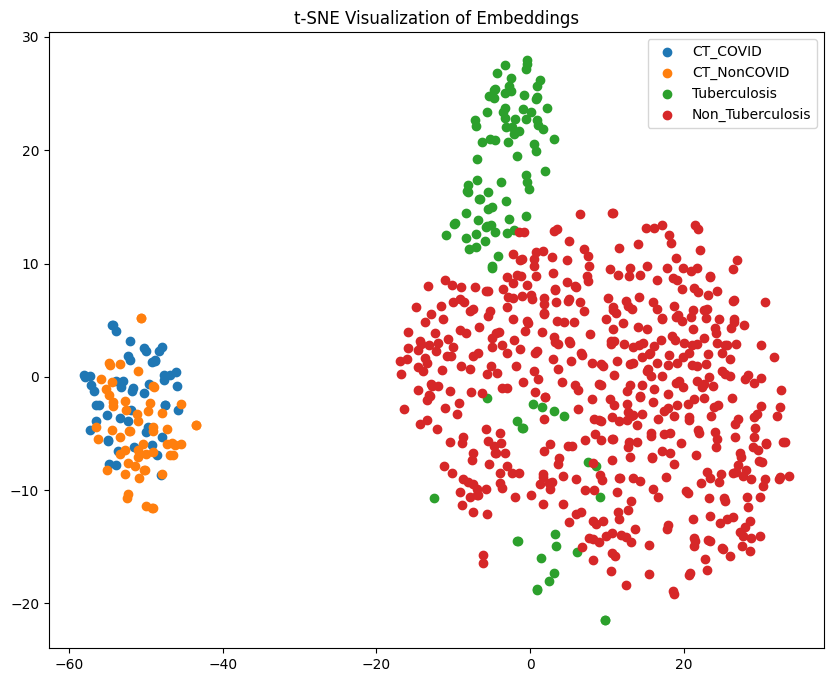

In [39]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Extract embeddings from the fused layer of the hybrid model
fused_layer_model = Model(inputs=model.input, outputs=model.get_layer('concatenate').output)
embeddings = fused_layer_model.predict(X_test)

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    indices = np.where(y_true_classes == i)
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=category)
plt.title('t-SNE Visualization of Embeddings')
plt.legend()
plt.show()
